In [1]:
import sys
sys.path.insert(0,'/home/acornelius/')
from startup import *
%matplotlib inline

### WOFOST runs off 5 essential components:
<br/>The weather file - 6 environmental parameters for the location every day we are interested in.
<br/>The crop file - all the parameters that say how a certain species reacts to environmental pressures.
<br/>The agromanager - the timings of planting and other significant events.
<br/>The soil object - the information about how the soil at each timestep.
<br/>The site object - extra information about the site we are interested in.

In [6]:
crop = CABOFileReader(woroot+'params/henan_crop_params.CAB')
soil = CABOFileReader(woroot+'params/Hengshui.soil')
site = WOFOST71SiteDataProvider(WAV=100, CO2=360)
parameters = ParameterProvider(crop,soil,site)
weather = CABOWeatherDataProvider('F01283_CF00637HB*')
agromanagement = YAMLAgroManagementReader('timer.amgt')

To run WOFOST we establish a parameter obecjt - which just combines the different aspects and tells WOFOST we wantr these bits

In [7]:
parameter_object = ParameterProvider(crop,soil,site)

Then we set up a WOFOST object that brings all the 5 aspects together.

In [8]:
wofost = Wofost71_PP(parameter_object, 
                       weather, 
                       agromanagement)

And run it to get some results (hopefully)...

In [9]:
wofost.run_till_terminate()
print ('Finished WOFOST run')

Finished WOFOST run


### Lets look at some results

In [10]:
results = wofost.get_output()

Each timesetp is stored in a list, with all the parameters in each timestep. This is what day 4 looks like for example:

In [11]:
results[3]

{'DVS': -0.09666666666666668,
 'LAI': 0.1446522,
 'RD': 10.0,
 'SM': 0.3,
 'TAGP': 105.0,
 'TRA': 0.0,
 'TWLV': 71.61,
 'TWRT': 105.0,
 'TWSO': 0.0,
 'TWST': 33.39,
 'WWLOW': None,
 'day': datetime.date(2017, 1, 4)}

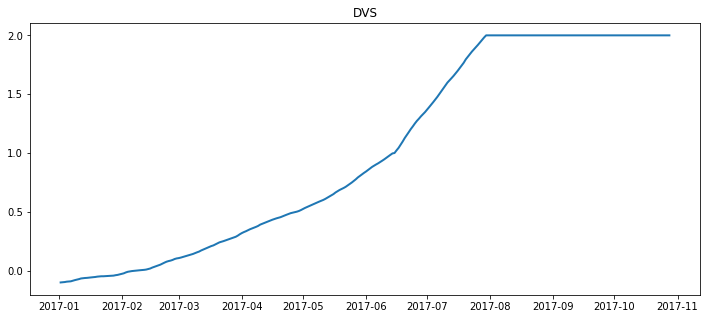

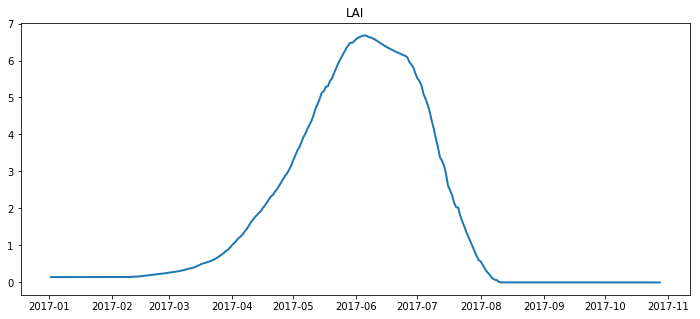

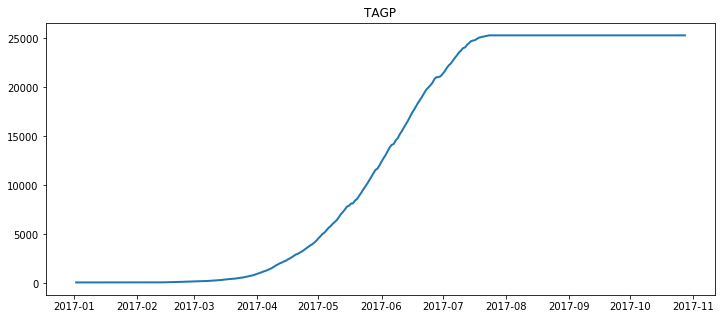

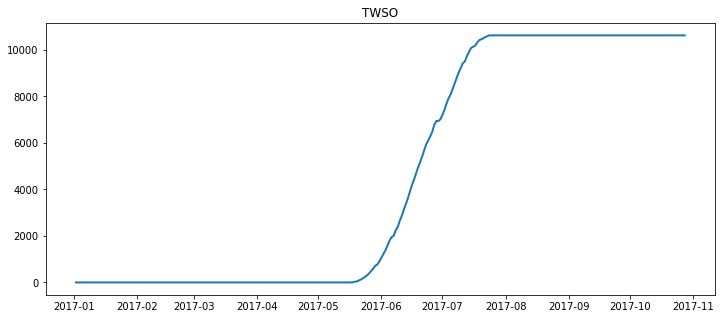

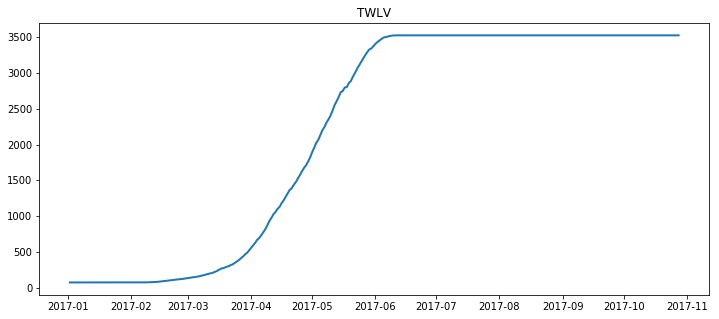

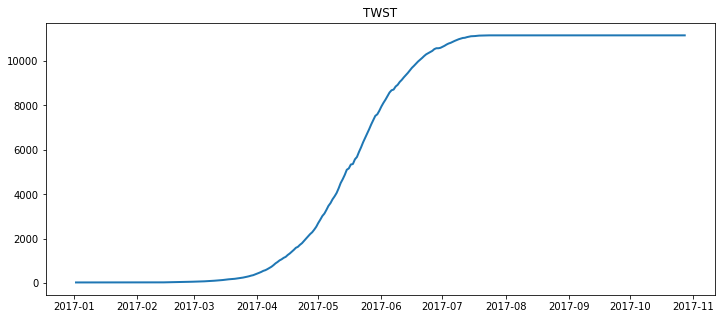

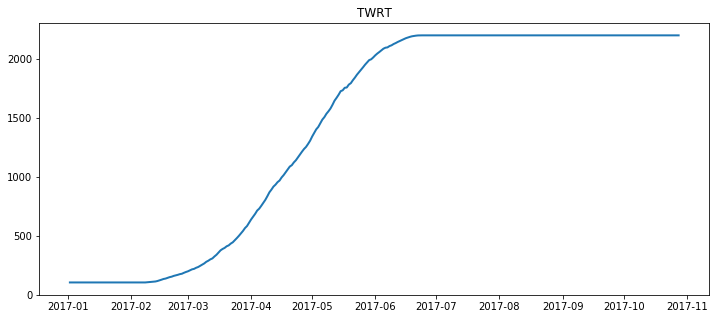

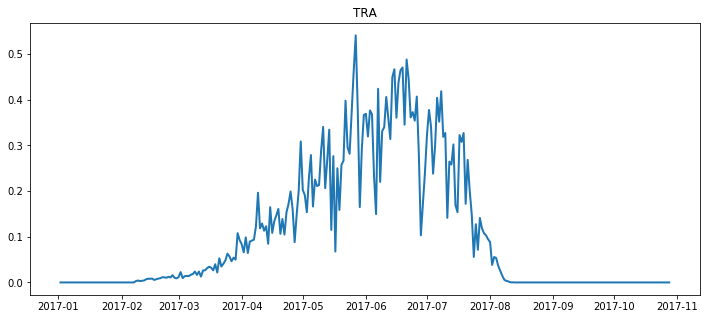

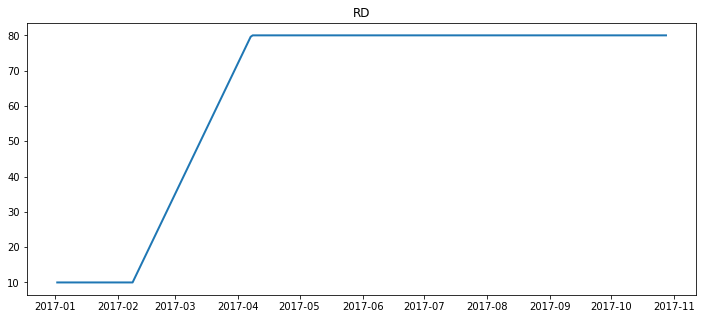

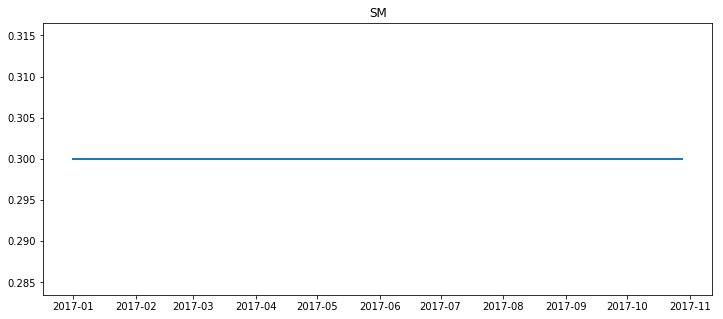

In [12]:
# here is a list of all the parameters:
params = list(results[0].keys())
params = [i for i in params if i not in ['day', 'WWLOW']]


# here are the timesteps
time = [i['day'] for i in results]

# loop through the parameters
for i in params:
    p_data = [j[i] for j in results]
    plt.figure(figsize=(12,5))
    plt.plot(time,p_data, lw=2)
    plt.title(i)

### Lets experience our first problem - hyper sensitivity!
We will tweek one of the parameters and compare the differences to the model we run above

In [10]:
crop['CVO']

0.8

In [66]:
crop['SPAN']

30.0

In [69]:
new = [0.0, 0.00202, 0.2, 0.00181, 0.4, 0.00155, 0.7, 0.00261, \
       1.0, 0.00551, 1.6, 0.00485, 2.0, 0.00274]

to_change = 'SPAN'
new_value = 41

new_crop = copy.deepcopy(crop)
new_crop[to_change] = new_value

new_parameter_object = ParameterProvider(new_crop,soil,site)

new_wofost = Wofost71_PP(new_parameter_object, 
                       weather, 
                       agromanagement)

new_wofost.run_till_terminate()

new_results = new_wofost.get_output()

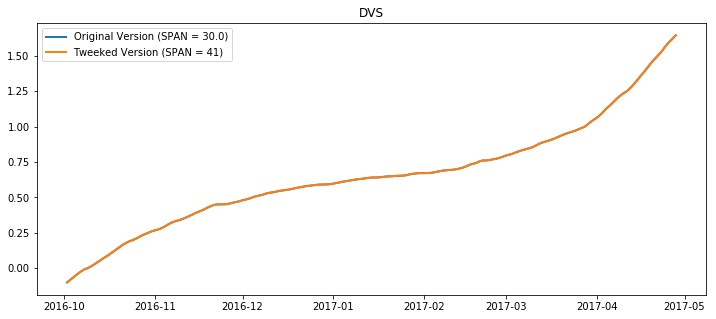

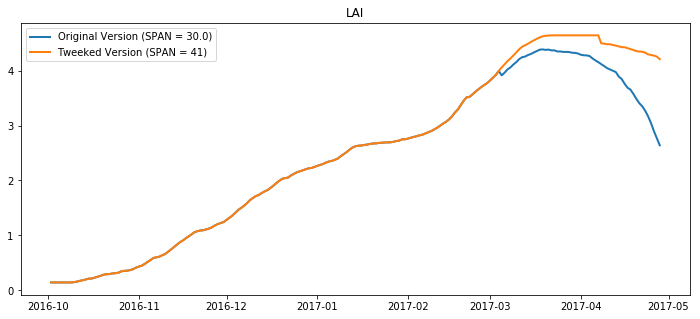

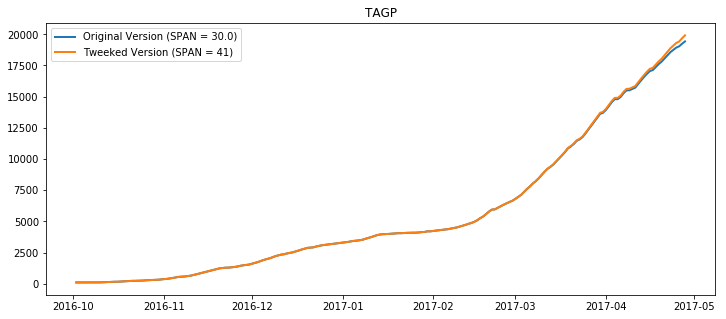

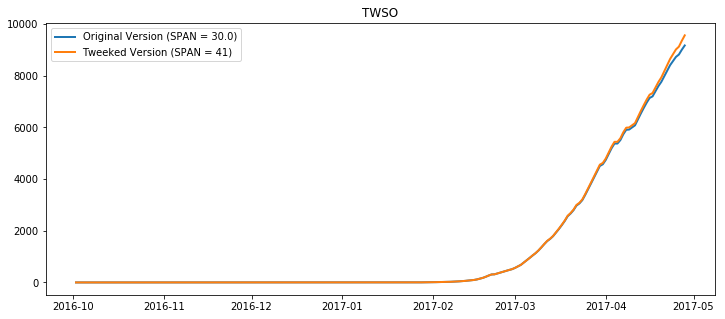

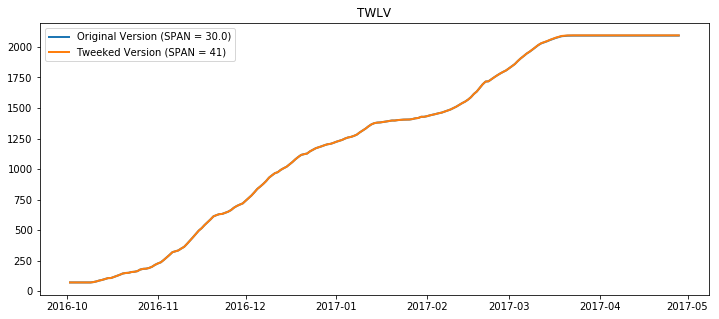

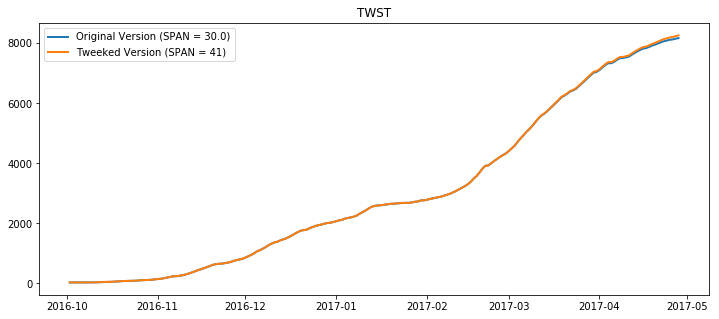

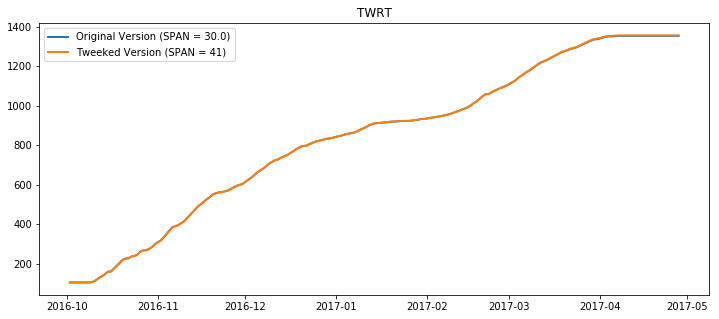

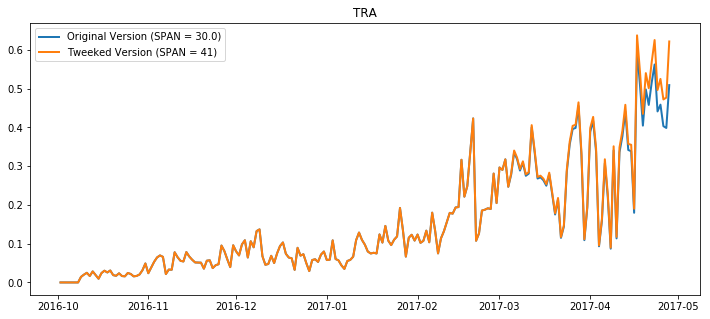

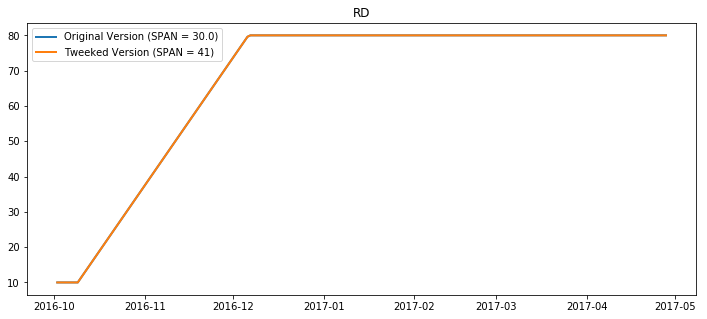

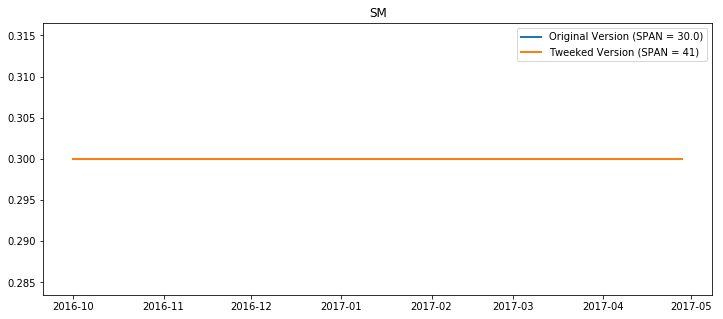

In [70]:
# loop through the parameters
for i in params:
    
    p_data = [j[i] for j in results]
    
    p_data2 = [j[i] for j in new_results]
    
    plt.figure(figsize=(12,5))
    plt.plot(time,p_data, lw=2, label='Original Version (%s = %s)'%(to_change, crop[to_change]))
    plt.plot(time,p_data2,lw=2, label='Tweeked Version (%s = %s)'%(to_change,new_value))
    plt.title(i)
    plt.legend()

## How do we get around this problem? How do know the variation in a location?
 - Calibrate - VERY long process, needs allot of calibration data and will be location specific.
 - OR Run the model lots of times and get a spread of results.
 
Running the model lots of times is the direction we are interested in at Assimila. It is easy, nicely general approach and we can interpret the results in very novel ways

In [12]:
# import our ensemble modules
from enwofost import enwofost

/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/acornelius/enwofost/running/enwofost.py:667: RuntimeWarning: invalid value encountered in greater
  capped = np.where(im_cap > max_val)


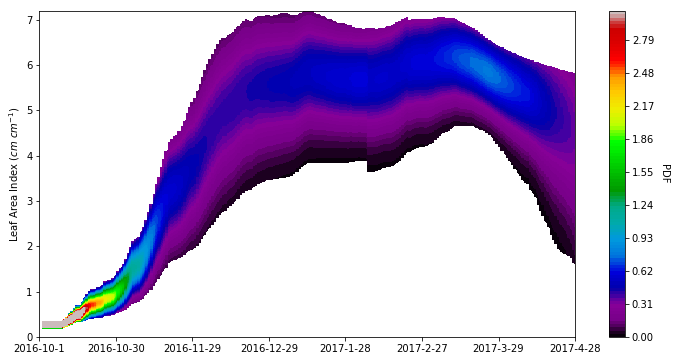

In [14]:
num_of_ensembles = 10

ens = enwofost(num_of_ensembles, 'potential')
ens.Generate_With_Dists_From_Objects('par_prior.csv',crop,soil,site,weather,agromanagement)

ens.PDF_Image('LAI')

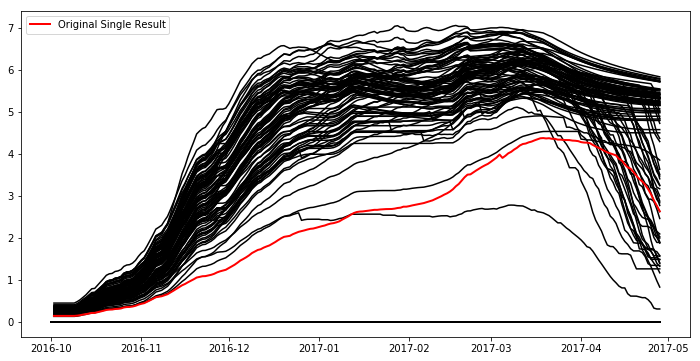

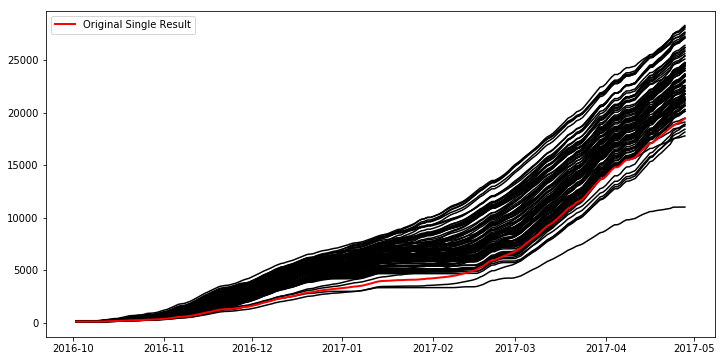

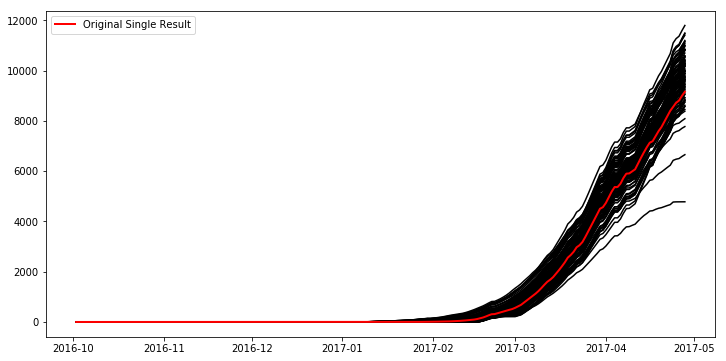

In [13]:
for i in ['LAI', 'TAGP', 'TWSO']:
    try:
        p_ens = ens.Extract_Params([i])[i]
        
        plt.figure(figsize=(12,6))
        
        for j in p_ens:
            plt.plot(ens.Time(), j,c='k')
        
        plt.plot(time,[j[i] for j in results],lw='2',c='r',label='Original Single Result')
        plt.legend()
    except:
        pass    

## So what can we actually do with this method? Why is this usefull?

### Introducing COFOST - a datacube plugin.
A method to visually compare how favourable this years weather is for crops, compared to other years of data. N number of ensembles are created for all past years so we understand the spread of data for each year. Then the current years ensembles are compared to all other ensembles.

In [14]:
import importlib

In [15]:
from importlib import reload
import enwofost_utils
reload(enwofost_utils)
from enwofost_utils import populate_agromanager

cofost_timer = populate_agromanager(agromanagement, weather,dt.date(2017,10,15),  dt.date(2018,6,20))

In [57]:
# generate ensembles for all years of data
ens = 10

cofost = enwofost(ens, 'potential')

cofost.Generate_With_Dists_From_Objects('par_prior.csv',crop,soil,site,weather,cofost_timer)

In [58]:
cofost_outputs = cofost.Get_Outputs()

In a really crude way, we can eyball the current years worth of data and compare it to other years.

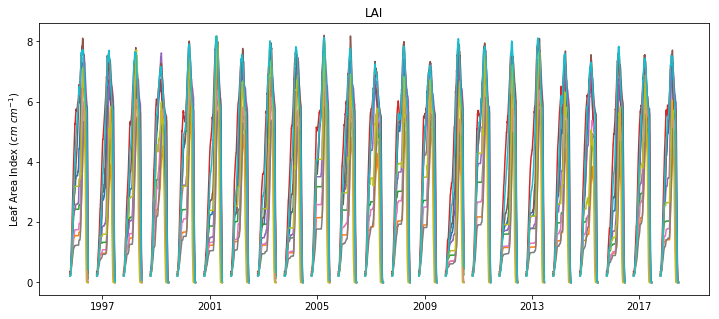

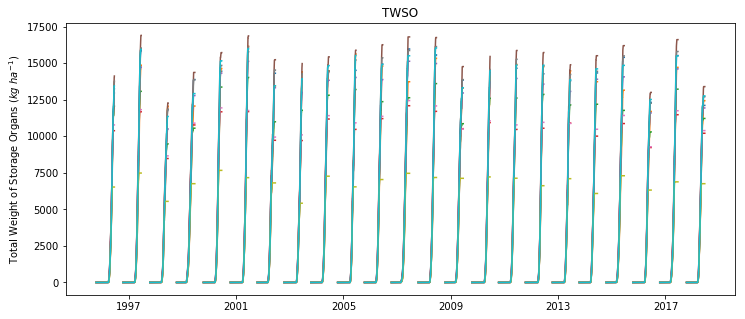

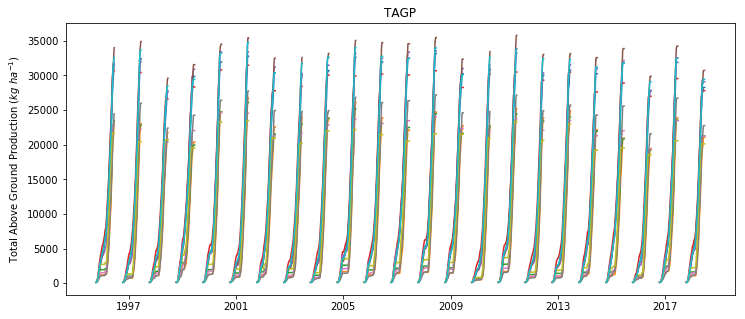

In [18]:
for i in ['LAI', 'TWSO', 'TAGP']:
    plt.figure(figsize=(12,5))
    plt.ylabel(cofost._units(i))
    plt.title(i)
    for j in cofost_outputs:
        plt.plot([k['day'] for k in j], 
                [k[i] for k in j])

In [19]:
from enwofost_utils import doy_plot

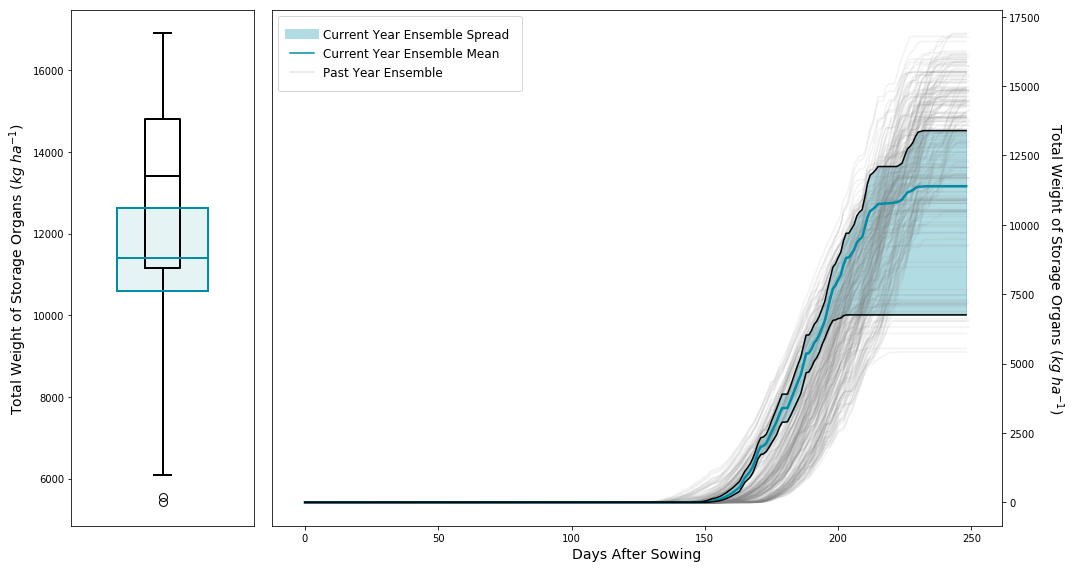

In [33]:
doy_plot(cofost, cofost_timer, 'TWSO')

In [37]:
from enwofost_utils import oneD_boxplots

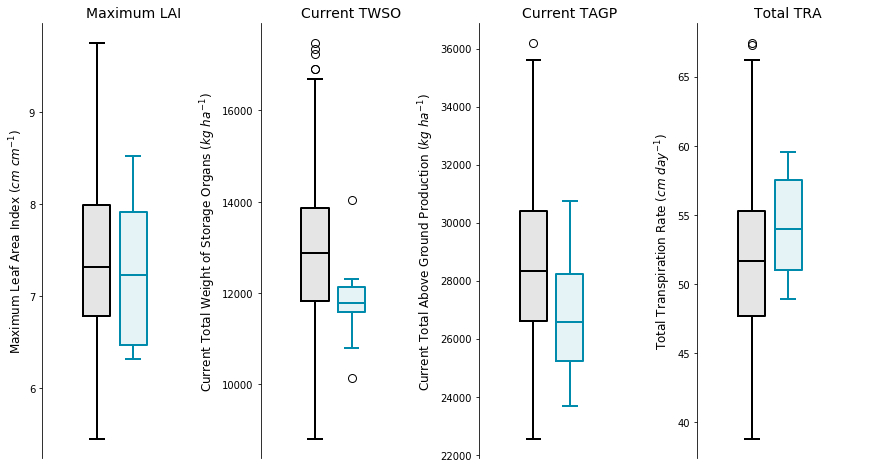

In [63]:
oneD_boxplots(cofost, cofost_timer)

In [61]:
def dashboard2(model, agromanagement):
    
    import numpy as np
    import datetime as dt
    import matplotlib.pyplot as plt
    
    
    def getlast(in_array):
        return in_array[-1]
    
    # the parameter corresponds with the operators
    target_parameters = ['LAI', 'TAGP',  'TWLV', 'TWST', 'TWRT', 'TRA', 'TWSO']
    toperators = [np.nanmax, getlast, getlast, getlast, getlast, np.nansum, getlast]

    assim = [0, 0.54078125, 0.67453125]

    fig,axs = plt.subplots(1,len(target_parameters)+1,figsize=(2*len(target_parameters)+1,8))

    for n,target_p in enumerate(target_parameters):

        yd_all = []

        yd_target = []

        ea = model.Extract_Params([target_p])

        for i in agromanagement:

            start = list(i.keys())[0]
            end = i[start]['CropCalendar']['crop_end_date']

            year_index = np.where((model.Time() >= start) & (model.Time() <= end))

            for j in ea[target_p]:

                year_slice = j[year_index]

                if i != agromanagement[-1]:
                    yd_all.append(toperators[n](year_slice))

                else:
                    yd_target.append(toperators[n](year_slice))  
                    yd_all.append(toperators[n](year_slice))

        mu = np.mean(yd_all)
        sigma = np.std(yd_all)

        #lower = mu - (3*sigma)
        lower = np.min(yd_all)

        #if np.mean(yd_target) < lower: lower = np.min(yd_all)

        #upper = mu + (3*sigma)
        upper = np.max(yd_all)
        #if np.mean(yd_target) > upper: lower = np.max(yd_all)

        height = 150
        width = 20

#         axs[0].scatter(np.repeat(1,len(yd_all)), yd_all)
#         axs[0].scatter(np.repeat(2,len(yd_target)), yd_target)
        
#         axs[0].scatter(1.1,np.mean(yd_all))
#         axs[0].scatter(1.9,np.mean(yd_target))
#         axs[0].set_xlim(0,3)
        
        tmu = (np.mean(yd_target)/upper)*height

        im = np.zeros([height,width])

        vertical = np.linspace(lower,upper,height)

        for i in range(width):

            im[:,i] = np.arange(height)

    #         im[:,i] = scipy.stats.truncnorm.pdf(
    #                     vertical, (lower - mu) / sigma, (upper - mu)\
    #                     / sigma,loc=mu,scale=sigma)

        axs[n].imshow(im,origin='lower', cmap='YlGn')

        axs[n].spines["top"].set_visible(False)
        axs[n].spines["right"].set_visible(False)
        axs[n].spines["bottom"].set_visible(False)
        axs[n].spines['left'].set_visible(False)

        axs[n].axes.get_xaxis().set_ticks([])
        axs[n].axes.get_yaxis().set_ticks([])

        extra = 2.5
        height = 5

        axs[n].plot((0-extra,width+extra-1),(tmu,tmu),c='k',lw=4)
    #     axs[n].plot((0-extra,0-extra),(max(tmu-height,0),tmu+height),c='k', lw=4)
    #     axs[n].plot((width+extra-1,width+extra-1),(max(tmu-height,0),tmu+height),c='k', lw=4)

        axs[n].set_title(target_p)

    axs[-1].plot([], [], c='k', lw=4, label='Current\nGrowing\nSeason\nMean')
    axs[-1].legend(fontsize=14,loc=10)
    axs[-1].spines["top"].set_visible(False)
    axs[-1].spines["right"].set_visible(False)
    axs[-1].spines["bottom"].set_visible(False)
    axs[-1].spines['left'].set_visible(False)

    axs[-1].axes.get_xaxis().set_ticks([])
    axs[-1].axes.get_yaxis().set_ticks([]) 

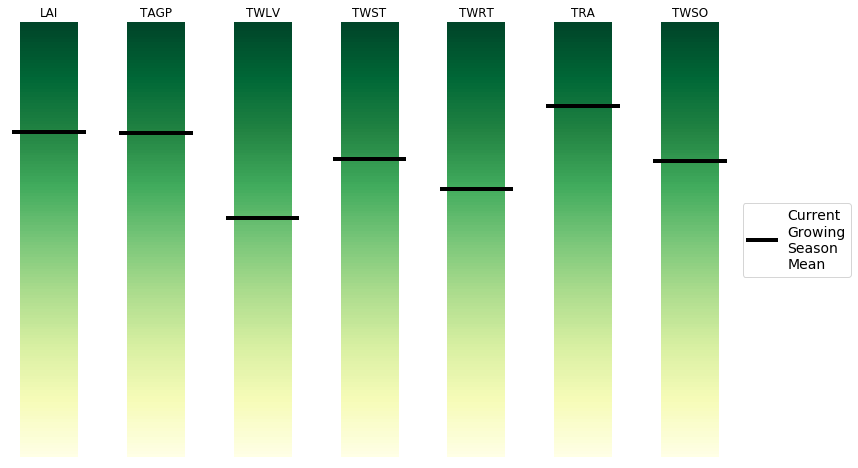

In [62]:
dashboard2(cofost, cofost_timer)